In [127]:
!pip install torch torchvision transformers opencv-python scikit-learn googletrans==4.0.0rc1

In [128]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [129]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle, class_weight
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import random


In [130]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [131]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label'], dtype='object')


In [132]:
print(df['label'].unique())


['Anthropogenic' 'Non Informative' 'Fire' 'flood' 'Cyclone'
 'River Erosion' 'Earthquake']


In [133]:
import pandas as pd

# Define the mapping
label_mapping = {
    'flood': 0,
    'Cyclone': 1,
    'Earthquake': 2,
    'River Erosion': 3,
    'Fire' : 4,
    'Anthropogenic': 5
}

# Remove 'Non Informative' rows
df = df[df['label'] != 'Non Informative']

# Assign new integer labels
df['label'] = df['label'].map(label_mapping)

# Display updated labels
print(df['label'].unique())


[5 4 0 1 3 2]


In [134]:
print(df['label'].value_counts())

label
5    697
0    510
1    509
4    505
2    500
3    445
Name: count, dtype: int64


In [135]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [136]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

# # Prepare data for TextDataset
# X_train = train_data['caption'].values
# y_train = train_data['label'].values
# X_valid = valid_data['caption'].values
# y_valid = valid_data['label'].values
# X_test = test_data['caption'].values
# y_test = test_data['label'].values


In [137]:
# Data augmentation functions
def random_deletion_bn(text, p=0.1):
    words = text.split()
    if len(words) == 1:
        return text
    remaining = [w for w in words if random.uniform(0,1) > p]
    if not remaining:
        return random.choice(words)
    return ' '.join(remaining)

def random_swap_bn(text, n=1):
    words = text.split()
    length = len(words)
    if length < 2:
        return text
    for _ in range(n):
        idx1, idx2 = random.sample(range(length), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def char_noise_bn(text, p=0.03):
    noisy_text = ''
    for c in text:
        if random.uniform(0,1) < p and c != ' ':
            noisy_text += random.choice('অআইঈউঊঋএঐওঔকখগঘচছজঝটঠডঢতথদধনপফবভমযরলশষসহ')
        else:
            noisy_text += c
    return noisy_text

def augment_bengali_text(text):
    aug_choice = random.choice(['delete', 'swap', 'char_noise', 'none'])
    if aug_choice == 'delete':
        return random_deletion_bn(text, p=0.1)
    elif aug_choice == 'swap':
        return random_swap_bn(text, n=1)
    elif aug_choice == 'char_noise':
        return char_noise_bn(text, p=0.03)
    else:
        return text

# Apply augmentation to training data
train_data, val_test = train_test_split(df, train_size=0.6, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=0.5, random_state=42)
train_data['caption_aug'] = train_data['caption'].apply(augment_bengali_text)

In [138]:
# Prepare data
X_train = train_data['caption_aug'].values
y_train = train_data['label'].values
X_valid = valid_data['caption'].values
y_valid = valid_data['label'].values
X_test = test_data['caption'].values
y_test = test_data['label'].values

In [139]:
# # Build vocabulary
# vocab = set(' '.join(X_train).split())
# word2idx = {word: idx + 1 for idx, word in enumerate(vocab)}  # 0 is reserved for padding
# word2idx['<PAD>'] = 0

# # Create embeddings matrix (random for demonstration; replace with fastText)
# embedding_dim = 300
# vocab_size = len(word2idx)
# embedding_matrix = np.random.rand(vocab_size, embedding_dim).astype(np.float32)
# # Uncomment to use fastText embeddings (upload cc.bn.300.bin to Kaggle)
# # fasttext_model = KeyedVectors.load_word2vec_format('/kaggle/input/cc.bn.300.bin', binary=True)
# # for word, idx in word2idx.items():
# #     if word in fasttext_model:
# #         embedding_matrix[idx] = fasttext_model[word]

# # Define tokenization function
# def tokenize(text, max_length=50):
#     tokens = text.split()[:max_length]
#     token_ids = [word2idx.get(token, 0) for token in tokens]
#     if len(token_ids) < max_length:
#         token_ids += [0] * (max_length - len(token_ids))
#     return token_ids

In [140]:
from transformers import BertModel
bert_model = BertModel.from_pretrained('sagorsarker/bangla-bert-base')
embedding_matrix = bert_model.get_input_embeddings().weight.detach().numpy()
embedding_dim = embedding_matrix.shape[1]  # 768
vocab_size = embedding_matrix.shape[0]  # 101,975

tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')

In [141]:
# Modified TextDataset to align with LSTM input
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text,
                                  max_length=self.max_length,
                                  padding='max_length',
                                  truncation=True,
                                  return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Shape: (max_length,)
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [142]:
# Create datasets and dataloaders (unchanged)
train_dataset = TextDataset(X_train, y_train, tokenizer)
valid_dataset = TextDataset(X_valid, y_valid, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [143]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [144]:
# """
# BiLSTM + Non-linear Attention + LayerNorm + Label-Smoothing +
# Grad-clip + Warm-up-Cosine schedule + smarter early-stopping
# """
# import torch, math
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm
# from sklearn.metrics import classification_report
# import matplotlib.pyplot as plt
# from transformers import get_cosine_schedule_with_warmup         # pip install transformers

# # ───────────────────────────────────────── Attention ──────────────────────────────────────────
# class Attention(nn.Module):
#     def __init__(self, hidden_dim):
#         super().__init__()
#         self.attn = nn.Sequential(
#             nn.Linear(hidden_dim * 2, hidden_dim),
#             nn.Tanh(),
#             nn.Linear(hidden_dim, 1)
#         )

#     def forward(self, lstm_out):                     # lstm_out: [B, T, 2H]
#         weights = torch.softmax(self.attn(lstm_out), dim=1)      # [B, T, 1]
#         ctx = torch.sum(weights * lstm_out, dim=1)               # [B, 2H]
#         return ctx
# # ───────────────────────────────────────── Model ──────────────────────────────────────────────
# class BiLSTMClassifier(nn.Module):
#     def __init__(self, vocab_size, embed_dim, hidden_dim, out_dim,
#                  n_layers, dropout, emb_matrix=None, freeze_emb=False):
#         super().__init__()
#         self.embedding = nn.Embedding(vocab_size, embed_dim)
#         if emb_matrix is not None:
#             self.embedding.weight = nn.Parameter(torch.tensor(emb_matrix, dtype=torch.float32))
#             self.embedding.weight.requires_grad = not freeze_emb

#         self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers,
#                             dropout=dropout if n_layers > 1 else 0,
#                             batch_first=True, bidirectional=True)

#         self.attn  = Attention(hidden_dim)
#         self.norm  = nn.LayerNorm(hidden_dim * 2)     # LayerNorm after attention
#         self.drop  = nn.Dropout(dropout)
#         self.fc    = nn.Linear(hidden_dim * 2, out_dim)

#     def forward(self, text):                          # text: [B, T]
#         x = self.drop(self.embedding(text))
#         lstm_out, _ = self.lstm(x)
#         ctx = self.attn(lstm_out)
#         ctx = self.norm(ctx)
#         return self.fc(self.drop(ctx))
# # ──────────────────────────────────── Label-smoothing loss ────────────────────────────────────
# class LabelSmoothingLoss(nn.Module):
#     def __init__(self, classes: int, smoothing: float = 0.1):
#         super().__init__()
#         self.confidence = 1.0 - smoothing
#         self.smoothing  = smoothing
#         self.cls        = classes
#         self.kl_div     = nn.KLDivLoss(reduction='batchmean')

#     def forward(self, logits, target):                # logits: [B, C], target: [B]
#         log_probs = torch.log_softmax(logits, dim=-1)
#         true_dist = torch.zeros_like(log_probs).fill_(self.smoothing / (self.cls - 1))
#         true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
#         return self.kl_div(log_probs, true_dist)

In [145]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, out_dim,
                 n_layers, dropout, emb_matrix=None, freeze_emb=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        if emb_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(emb_matrix, dtype=torch.float32))
            self.embedding.weight.requires_grad = not freeze_emb

        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers,
                            dropout=dropout if n_layers > 1 else 0,
                            batch_first=True, bidirectional=True)

        self.norm  = nn.LayerNorm(hidden_dim * 2)
        self.drop  = nn.Dropout(dropout)
        self.fc    = nn.Linear(hidden_dim * 2, out_dim)

    def forward(self, text):                  # text: [B, T]
        x = self.drop(self.embedding(text))  # [B, T, E]
        lstm_out, (h_n, _) = self.lstm(x)    # h_n: [2, B, H]
        h = torch.cat((h_n[-2], h_n[-1]), dim=1)  # [B, 2H]
        h = self.norm(h)
        return self.fc(self.drop(h))
        
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes: int, smoothing: float = 0.1):
        super().__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing  = smoothing
        self.cls        = classes
        self.kl_div     = nn.KLDivLoss(reduction='batchmean')

    def forward(self, logits, target):                # logits: [B, C], target: [B]
        log_probs = torch.log_softmax(logits, dim=-1)
        true_dist = torch.zeros_like(log_probs).fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return self.kl_div(log_probs, true_dist)

In [146]:
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=.3)  # maybe reduce to 0.5 or 0.3
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    return total_loss / len(data_loader), all_preds, all_labels

Evaluating: 100%|██████████| 20/20 [00:00<00:00, 43.64it/s]


Epoch 01 | train: 1.4174 | val: 1.3012


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 41.81it/s]


Epoch 02 | train: 1.3675 | val: 1.2968


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 41.03it/s]


Epoch 03 | train: 1.3160 | val: 1.2745


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 39.67it/s]


Epoch 04 | train: 1.2800 | val: 1.2534


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 41.79it/s]


Epoch 05 | train: 1.2481 | val: 1.1646


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 43.73it/s]


Epoch 06 | train: 1.1174 | val: 0.9495


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 42.13it/s]


Epoch 07 | train: 0.9764 | val: 0.7989
Unfreezing embeddings …


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 46.70it/s]


Epoch 08 | train: 0.8325 | val: 0.6057


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 46.04it/s]


Epoch 09 | train: 0.6267 | val: 0.4924


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 43.92it/s]


Epoch 10 | train: 0.5020 | val: 0.4329


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 37.71it/s]


Epoch 11 | train: 0.4085 | val: 0.4285


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 45.89it/s]


Epoch 12 | train: 0.3459 | val: 0.3625


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 46.48it/s]


Epoch 13 | train: 0.3016 | val: 0.3403


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 45.88it/s]


Epoch 14 | train: 0.2725 | val: 0.3312


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 46.27it/s]


Epoch 15 | train: 0.2607 | val: 0.3223


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 46.54it/s]


Epoch 16 | train: 0.2419 | val: 0.3165


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 46.05it/s]


Epoch 17 | train: 0.2282 | val: 0.3132


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 45.20it/s]


Epoch 18 | train: 0.2244 | val: 0.3148


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 46.03it/s]


Epoch 19 | train: 0.2171 | val: 0.3129


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 46.18it/s]


Epoch 20 | train: 0.2196 | val: 0.3124


<ipython-input-148-19fad1226cbf>:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_lstm_model.pt"))
Evaluating: 100%|██████████| 20/20


Test  loss : 0.2631
Test metrics:
               precision    recall  f1-score   support

        flood       0.92      0.88      0.90       114
      Cyclone       0.89      0.91      0.90        93
   Earthquake       0.90      0.95      0.92        84
River Erosion       0.84      0.85      0.85       101
         Fire       0.92      0.91      0.91       112
Anthropogenic       0.93      0.91      0.92       130

     accuracy                           0.90       634
    macro avg       0.90      0.90      0.90       634
 weighted avg       0.90      0.90      0.90       634



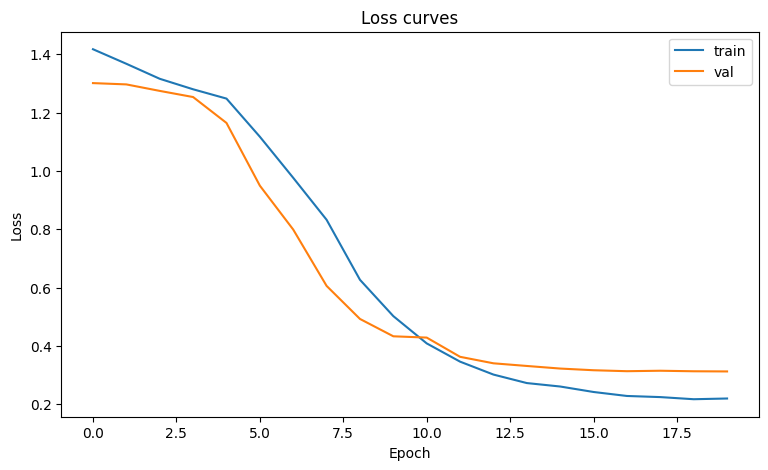

In [148]:
device        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_dim    = 32
n_layers      = 1
dropout       = 0.4                   # ↓ a bit to keep signal
output_dim    = 6
epochs        = 20
patience      = 3
min_delta     = 1e-4

model = BiLSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim,
                         n_layers, dropout, embedding_matrix,
                         freeze_emb=True).to(device)

criterion = LabelSmoothingLoss(classes=output_dim, smoothing=0.1)

# differential LR + lighter weight decay
optimizer = optim.Adam([
    {'params': model.embedding.parameters(), 'lr': 1e-4},
    {'params': list(model.lstm.parameters()) +
                list(model.norm.parameters()) +
                list(model.fc.parameters())}
], lr=5e-4, weight_decay=1e-4)

# warm-up + cosine schedule (per-batch)
total_steps  = len(train_loader) * epochs
warmup_steps = int(0.1 * total_steps)
scheduler    = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

best_val_loss   = math.inf
epochs_no_imprv = 0
train_losses, val_losses = [], []

# ─────────────────────────────────── Training loop ────────────────────────────────────────────
for epoch in range(epochs):
    # --- unfreeze embeddings mid-way ---------------------------------------------------------
    if epoch == 7:
        print("Unfreezing embeddings …")
        for pg in optimizer.param_groups:
            for p in pg['params']:
                if p is model.embedding.weight:
                    pg['lr'] = 1e-4
        model.embedding.weight.requires_grad = True

    model.train()
    running_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        # batch can be tuple or dict → handle both
        if isinstance(batch, dict):
            inp = batch.get('input_ids', batch.get('text')).to(device)
            lbl = batch['labels'].to(device)
        else:
            inp, lbl = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        logits = model(inp)
        loss   = criterion(logits, lbl)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # grad-clip
        optimizer.step()
        scheduler.step()  # step **per batch** with warm-up-cosine

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    val_loss, val_preds, val_lbls = evaluate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1:02d} | train: {train_loss:.4f} | val: {val_loss:.4f}")

    # ─ smarter early-stopping ─
    if best_val_loss - val_loss > min_delta:
        best_val_loss   = val_loss
        epochs_no_imprv = 0
        torch.save(model.state_dict(), "best_lstm_model.pt")
    else:
        epochs_no_imprv += 1
        if epochs_no_imprv >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
# ──────────────────────────────── Test & plots ───────────────────────────────────────────────
model.load_state_dict(torch.load("best_lstm_model.pt"))
test_loss, test_preds, test_lbls = evaluate(model, test_loader, criterion, device)

print(f"\nTest  loss : {test_loss:.4f}")
print("Test metrics:")
print(classification_report(test_lbls, test_preds, target_names=label_mapping.keys()))

plt.figure(figsize=(9,5))
plt.plot(train_losses, label="train")
plt.plot(val_losses,   label="val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss curves"); plt.legend(); plt.show()

In [ ]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_lstm_model.pt'))
test_loss, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Metrics:\n{classification_report(test_labels, test_preds, target_names=label_mapping.keys())}')

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix_lstm.png')
plt.show()

# Plot train and validation loss curves
print("Epoch | Train Loss | Validation Loss")
print("-" * 30)
for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses), 1):
    print(f"{i:5d} | {train_loss:.4f}    | {val_loss:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()